In [2]:

import Analysis 
import mmap
import os
import gc
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import importlib
importlib.reload(Analysis)


<module 'Analysis' from '/home/jrufino/neutron_analysis/Analysis.py'>

In [3]:
# -------------------------------------------------------------------------------------------------------------------- #
# 1) In this cell we will load the binary data file, check its header and first event to understand its structure
# -------------------------------------------------------------------------------------------------------------------- #
# Channel number and run number to analyze
channel_number = 9
run_number = 96
data_filepath = f'/home/jrufino/PhD_Research/data/'

# Open binary file, and load the data from the binary file into a memory-map (mmap)
filename = f"{data_filepath}/DAQ_Compass/run_{run_number}/RAW/DataR_CH{channel_number}@V1730S_26980_run_{run_number}.BIN"
file = open(filename,"rb")
mm = mmap.mmap(file.fileno(), 0, access = mmap.ACCESS_READ)

# --------------------------------------------------------------------------------------------------------------------#
# Check header + 1st event data to 
# ------------------------------------------
# 1.) Know the data structure
# 2.) Know if waveform are present  
# 3.) Know how many events there are
# ------------------------------------------
mm_offset = 0 # Header is the first two bytes of the binary file
header_bytes = mm[mm_offset:mm_offset+2]
header = int.from_bytes(header_bytes, "little")

# Checking energy long (Channel (2 bytes), MeV (8 bytes), or both) based on header flag
check1 = bool(header & 0x1)
check2 = bool((header & 0x2) >> 1)
check3 = bool((header & 0x3) == 0x3)
if check1:
    energy_long_size = 2; print("energy long size = 2")
elif check2:
    energy_long_size = 8; print("energy long size = 8")
elif check3:
    energy_long_size = 10; print("energy long size = 10")  # 2 + 8 bytes
else:
    energy_long_size = 0

# Checking if waveform data is present, and if it is, what is the length of the waveform based on the first event
has_waveform = bool((header & 0x8) >> 3)
if has_waveform:
    mm_offset = 2 + 2 + 2 + 8 + energy_long_size + 2 + 4 + 1  # header + board + channel + timestamp + energy_long + energy_short + flags + waveform_code
    waveform_length_bytes = mm[mm_offset:mm_offset+4] 
    waveform_length = int.from_bytes(waveform_length_bytes, "little")
    print(f"Waveform length of first event: {waveform_length} samples")

# Calculating number of events in file
size = os.path.getsize(filename)
num_events_read = (size - 2) / (2 + 2 + 8 + 2 + 2 + 4 + 1 + 4 + waveform_length*2)  # approx estimate
print(f"File size: {size} bytes")
print(f"Number of events in file: {num_events_read}")
events_int = int(num_events_read)


energy long size = 2
Waveform length of first event: 248 samples
File size: 341260212 bytes
Number of events in file: 655010.0


In [ ]:
# -------------------------------------------------------------------------------------------------------------------- #
# 2a) In this block we will test out what the range of the PSD histogram should be with arbitrary integration parameters
# -------------------------------------------------------------------------------------------------------------------- #

# Integration parameters
integration_start = 10
integration_offset = 10   
integration_stop = waveform_length - 1
integration_method = 3

# Preallocate results
TEvt = 0; BEvt = 0; percent_complete = 10
waveform = np.zeros(waveform_length); baseline = np.zeros(40)
long_integral_list = np.zeros(events_int, dtype=np.float32)
PSD = np.zeros(events_int, dtype=np.float32)
index = 0
if has_waveform:
    TEvt = 0; BEvt = 0
    # Calculate PSD values for all events and store into arrays
    for k in range(events_int):
        PSD[k] = -1; long_integral_list[k] = -1 # Resetting PSD and long integral elements 
        # Collect waveform data for event 'k'
        waveform_start = 2 + (k + 1) * (23 + energy_long_size) + k*2*waveform_length
        waveform_end = waveform_start + waveform_length * 2
        waveform[:] = np.frombuffer(mm[waveform_start:waveform_end], dtype=np.uint16).astype(np.float32)
        waveform[:] = 15200 - waveform # this inverts the signal and estimates a baseline
        # Calculate a baseline and subtract it from the waveform
        baseline = waveform[:40].mean()
        waveform -= baseline
        # Compute first and second derivative of the waveform
        dx = 1  # Assuming uniform spacing
        derivative_waveform = np.gradient(waveform, dx)
        second_derivative_waveform = np.gradient(derivative_waveform, dx)
        # PSD Integration 
        short_integral, long_integral = Analysis.PSD_Integration(waveform, integration_start, integration_offset, integration_stop, integration_method)

        if ((long_integral > 0) and (short_integral > 0)):
            long_integral_list[k] = long_integral
            PSD[k] = short_integral / long_integral
            TEvt += 1
            percent_complete = ((TEvt + BEvt) / events_int) * 100
            Total_events_parsed = bool (percent_complete % 10)
            if not Total_events_parsed:
                print(f"Percent complete: {percent_complete:.2f}%, good events parsed: {TEvt}")
        if ((long_integral <= 0) or (short_integral <= 0)):
            PSD[k] = -1; long_integral_list[k] = -1 
            BEvt += 1
print(f"Percent complete: 100.00%, good events parsed: {TEvt}")
print(f"bad events parsed: {BEvt}")  
print(f"total events parsed: {TEvt + BEvt}")
gc.collect()  # Free up memory


Percent complete: 10.00%, good events parsed: 65501
Percent complete: 20.00%, good events parsed: 131002
Percent complete: 30.00%, good events parsed: 196503
Percent complete: 40.00%, good events parsed: 262004
Percent complete: 50.00%, good events parsed: 327505
Percent complete: 60.00%, good events parsed: 393006
Percent complete: 70.00%, good events parsed: 458507
Percent complete: 80.00%, good events parsed: 524008
Percent complete: 90.00%, good events parsed: 589509
Percent complete: 100.00%, good events parsed: 638469
bad events parsed: 16541
total events parsed: 655010


0

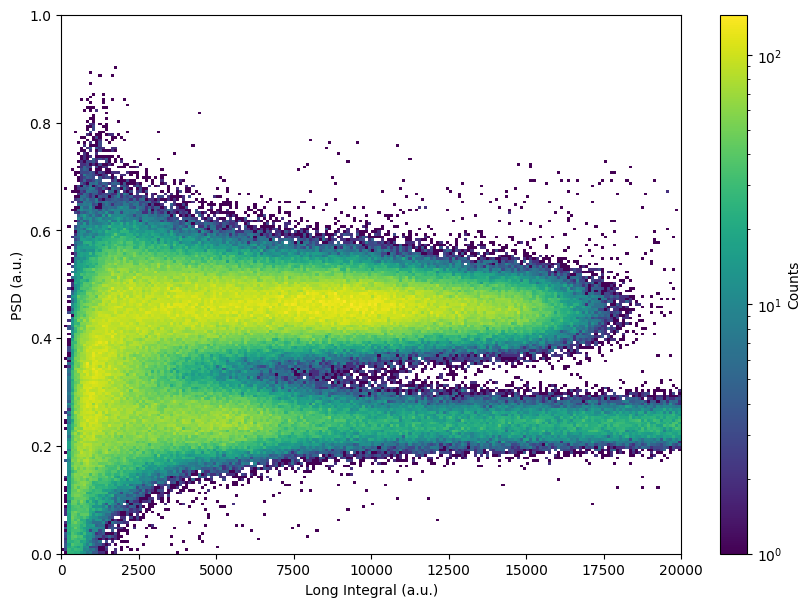

In [ ]:
# -------------------------------------------------------------------------------------------------------------------- #
# 2b) Plot PSD vs Long Integral Histogram to determine ranges for PSD histogram
# -------------------------------------------------------------------------------------------------------------------- #
# Keep only valid (finite) pairs
# mask = np.isfinite(PSD) & np.isfinite(long_integral_list) & (PSD > 0) & (long_integral_list > 0)
# PSD = PSD[mask]
# long_integral_list = long_integral_list[mask]
plt.figure(figsize=(10,7))

#Once you have determined the ranges, you can set them in the next line 
plt.hist2d(long_integral_list, PSD, range=[[0, max(long_integral_list)], [0, 1]], bins = [200,200], cmap='viridis', norm='log')
# plt.hist2d(long_integral_list, PSD, range=[[0, 20000], [0, 1]], bins = [200,200], cmap='viridis', norm='log')
plt.colorbar(label='Counts')
plt.xlabel('Long Integral (a.u.)')
plt.ylabel('PSD (a.u.)')
plt.show()

In [ ]:
# -------------------------------------------------------------------------------------------------------------------- #
# 3a) After finding the best integration parameters we can work on calibrating the detectors 
# using known gamma sources and their Compton edges. First we need to calculate the PSD values!
# -------------------------------------------------------------------------------------------------------------------- #
# Best integration parameters (from FOM analysis)
integration_start = 10
integration_offset = 17
integration_stop = 190
integration_method = 3

CFD_pileup_threshold = 0.45  # Threshold for pileup detection
CFD_thinpulse_threshold = 0.8  # Threshold for thin pulse detection
calibrate = False  # Whether to apply energy calibration or not

# Open binary file, and load the data from the binary file into a memory-map (mmap)
filename_cal = f"{data_filepath}analyzed/ch{channel_number}/137Cs_calibration.BIN"
file_cal = open(filename_cal,"rb")
mm_cal = mmap.mmap(file_cal.fileno(), 0, access = mmap.ACCESS_READ)
size_cal = os.path.getsize(filename_cal)
num_events_read_cal = (size_cal - 2) / (2 + 2 + 8 + 2 + 2 + 4 + 1 + 4 + waveform_length*2)  # approx estimate
events_int_cal = int(num_events_read_cal)

long_integral_list_cal = np.zeros(events_int_cal, dtype=np.float32)
PSD_cal = np.zeros(events_int_cal, dtype=np.float32)
TEvt = 0; BEvt = 0
if has_waveform:
    # Calculate PSD values for all events and store into arrays
    for k in range(events_int_cal):
        PSD_cal[k] = -1; long_integral_list_cal[k] = -1 # Resetting PSD and long integral elements 
        # Collect waveform data for event 'k'
        waveform_start = 2 + (k + 1) * (23 + energy_long_size) + k*2*waveform_length
        waveform_end = waveform_start + waveform_length * 2
        waveform[:] = np.frombuffer(mm_cal[waveform_start:waveform_end], dtype=np.uint16).astype(np.float32)
        waveform[:] = 15200 - waveform # this inverts the signal and estimates a baseline
        # Calculate a baseline and subtract it from the waveform
        baseline = waveform[:40].mean()
        waveform -= baseline
        # Compute first and second derivative of the waveform
        dx = 1  # Assuming uniform spacing
        derivative_waveform = np.gradient(waveform, dx)
        second_derivative_waveform = np.gradient(derivative_waveform, dx)
        # Check for pileup or thin pulse 
        pile_up_event = Analysis.Pileup_Filtering(second_derivative_waveform, CFD_pileup_threshold)
        thin_pulse_event = Analysis.Thin_Pulse_Filtering(waveform, channel_number, CFD_thinpulse_threshold)
        # PSD Integration 
        short_integral, long_integral = Analysis.PSD_Integration(waveform, integration_start, integration_offset, integration_stop, integration_method)

        if ((long_integral > 0) and (short_integral > 0) and (not thin_pulse_event)):
            long_integral_list_cal[k] = long_integral
            PSD_cal[k] = short_integral / long_integral
            TEvt += 1
            percent_complete = ((TEvt + BEvt) / events_int) * 100
            Total_events_parsed = bool (percent_complete % 10)
            if not Total_events_parsed:
                print(f"Percent complete: {percent_complete:.2f}%, good events parsed: {TEvt}")
        if ((long_integral <= 0) or (short_integral <= 0)):
            PSD_cal[k] = -1; long_integral_list_cal[k] = -1 
            BEvt += 1
print(f"Percent complete: 100.00%, good events parsed: {TEvt}")
print(f"bad events parsed: {BEvt}")  
print(f"total events parsed: {TEvt + BEvt}")
print("PSD calculation for calibration file completed.")
gc.collect()  # Free up memory


Total events parsed:	1000
Total events parsed:	2000
Total events parsed:	3000
Total events parsed:	4000
Total events parsed:	5000
Total events parsed:	6000
Total events parsed:	7000
Total events parsed:	8000
Total events parsed:	9000
Total events parsed:	10000
Total events parsed:	11000
Total events parsed:	12000
Total events parsed:	13000
Total events parsed:	14000
Total events parsed:	15000
Total events parsed:	16000
Total events parsed:	17000
Total events parsed:	18000
Total events parsed:	19000
Total events parsed:	20000
Total events parsed:	21000
Total events parsed:	22000
Total events parsed:	23000
Total events parsed:	24000
Total events parsed:	25000
Total events parsed:	26000
Total events parsed:	27000
Total events parsed:	28000
Total events parsed:	29000
Total events parsed:	30000
Total events parsed:	31000
Total events parsed:	32000
Total events parsed:	33000
Total events parsed:	34000
Total events parsed:	35000
Total events parsed:	36000
Total events parsed:	37000
Total even

80% height on high-energy side: 38040.4178516889
13.175416644934199, 0.12522393502217605, 4.377472245576056e-06
-11.981200024064119, 0.2187810374153178, -3.077909283577966e-06
6.038320448234116, 0.5702040664354859, -8.159986575209514e-06
-16.967337568833376, 0.559731245170577, -9.35120555834961e-06


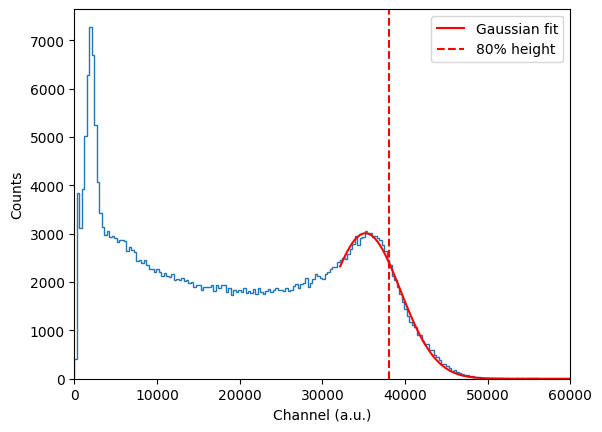

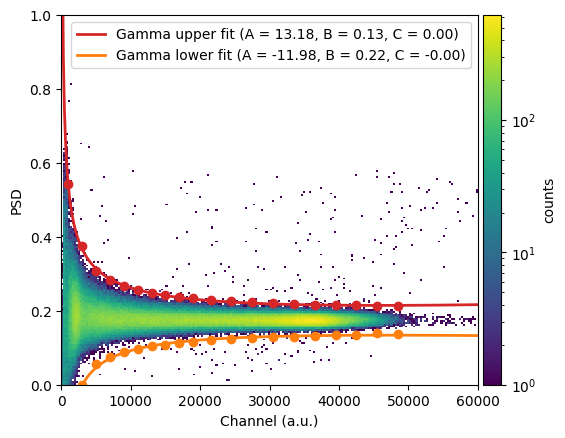

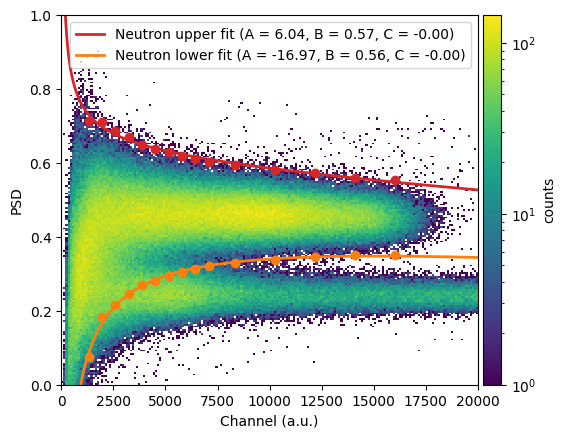

In [ ]:
# -------------------------------------------------------------------------------------------------------------------- #
# 3b) Calculate Compton edge calibration and light response fit on the Gamma band
# -------------------------------------------------------------------------------------------------------------------- #

# Histogram parameters for calibration (This is different as it depends on the detector and source used)
x_min_cal = 0; x_max_cal = 60000
y_min_cal = 0; y_max_cal = 1
x_bins_cal = 200; y_bins_cal = 200
lower_gate = 0; upper_gate = 50000
slices_in_region1 = 10; slices_in_region2 = 10
total_slices = slices_in_region1 + slices_in_region2

# Whether to apply energy calibration to the plot. This program will output the calibration parameters for you to use
calibrate = False  

# Compton edge calibration
Analysis.Compton_edge_calibration(long_integral_list_cal, x_min_cal, x_max_cal, x_bins_cal, channel_number, calibrate, save_filepath=f'{data_filepath}analyzed/ch{channel_number}/')
# If you copy the values from here to calibration.py, you can make calibrate = True

# Light response fit on the Gamma band
N_sigma = 4  # Number of sigmas for the upper and lower limits of the Gaussian fit
a0, b0, c0 = Analysis.Gamma_light_response_fit(PSD_cal, long_integral_list_cal, x_min_cal, x_max_cal, x_bins_cal, y_min_cal, y_max_cal, y_bins_cal, lower_gate, upper_gate, total_slices, slices_in_region1, slices_in_region2, N_sigma, channel_number, calibrate, save_filepath=f'{data_filepath}analyzed/ch{channel_number}/')

# Liht response fit on the Neutron band (This does not use calibration data - this uses the original data file)
integration_start = 10
integration_offset = 17   
integration_stop = 190
integration_method = 3
# Histogram parameters
x_min = 0; x_max = 20000
y_min = 0; y_max = 1
x_bins = 200; y_bins = 200
# PSD gate parameters
lower_gate = 1000; upper_gate = 17000
slices_in_region1 = 10; slices_in_region2 = 5
total_slices = slices_in_region1 + slices_in_region2

CFD_pileup_threshold = 0.45  # Threshold for pileup detection
CFD_thinpulse_threshold = 0.8  # Threshold for thin pulse detection
calibrate = False  # Whether to apply energy calibration or not
N_sigma = 3  # Number of sigmas for the upper and lower limits of the Gaussian fit
a1, b1, c1, a2, b2, c2 = Analysis.Neutron_light_response_fit(PSD, long_integral_list, x_min, x_max, x_bins, y_min, y_max, y_bins, lower_gate, upper_gate, total_slices, slices_in_region1, slices_in_region2, N_sigma, channel_number, calibrate, save_filepath=f'{data_filepath}analyzed/ch{channel_number}/')


In [57]:
# Calibration and light response analysis completed. Copy and past the following parameters into calibration_and_setup.py
print("if(channel == 9):")
print("    # Integration parameters")
print(f"    integration_start = {integration_start}")
print(f"    integration_offset = {integration_offset}")
print(f"    integration_stop = {integration_stop}")
print(f"    integration_method = {integration_method}")
print("    # Histogram parameters")
print(f"    x_min = {x_min}; x_max = {x_max} ")
print(f"    y_min = {y_min}; y_max = {y_max}")
print(f"    x_bins = {x_bins}; y_bins = {y_bins}")
print("    # PSD gate parameters")
print(f"    lower_gate = {lower_gate}; upper_gate = {upper_gate}")
print(f"    slices_in_region1 = {slices_in_region1}; slices_in_region2 = {slices_in_region2}")
print("    total_slices = slices_in_region1 + slices_in_region2")
print("    # Light curve fitting parameters")
print(f"    a0, b0, c0 = {a0}, {b0}, {c0}")
print(f"    a1, b1, c1 = {a1}, {b1}, {c1}")
print(f"    a2, b2, c2 = {a2}, {b2}, {c2}")
print("    return integration_start, integration_offset, integration_stop, integration_method, x_min, x_max, x_bins, y_min, y_max, y_bins, upper_gate, lower_gate, slices_in_region1, slices_in_region2, total_slices, a0, b0, c0, a1, b1, c1, a2, b2, c2")



if(channel == 9):
    # Integration parameters
    integration_start = 10
    integration_offset = 17
    integration_stop = 190
    integration_method = 3
    # Histogram parameters
    x_min = 0; x_max = 20000 
    y_min = 0; y_max = 1
    x_bins = 200; y_bins = 200
    # PSD gate parameters
    lower_gate = 1000; upper_gate = 17000
    slices_in_region1 = 10; slices_in_region2 = 5
    total_slices = slices_in_region1 + slices_in_region2
    # Light curve fitting parameters
    a0, b0, c0 = 13.175416644934199, 0.12522393502217605, 4.377472245576056e-06
    a1, b1, c1 = 6.038320448234116, 0.5702040664354859, -8.159986575209514e-06
    a2, b2, c2 = -16.967337568833376, 0.559731245170577, -9.35120555834961e-06
    return integration_start, integration_offset, integration_stop, integration_method, x_min, x_max, x_bins, y_min, y_max, y_bins, upper_gate, lower_gate, slices_in_region1, slices_in_region2, total_slices, a0, b0, c0, a1, b1, c1, a2, b2, c2
